Sample of the pipeline used to create, compile, and train convolutional neural networks for BrainStation Capstone

In [ ]:
#Packages Used
import keras
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import matplotlib
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Activation, Flatten, Conv2D, Conv1D,MaxPooling2D,Dropout,AveragePooling2D,BatchNormalization
from keras import models
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
#Create a function to pull values from history object
def epoch_vals(model_history):
    val_loss = model_history.history['val_loss']
    loss = model_history.history['loss']
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    epochs = range(1, len(acc) + 1)
    
    return val_loss,loss,acc,val_acc,epochs

In [21]:
#Load in Grey Scaled images
X_train = np.load('X_train_greyscaled.npy')
X_test = np.load('X_test_greyscaled.npy')
y_test_full = np.load('y_test_greyscaled.npy')
y_train_full = np.load('y_train_greyscaled.npy')

#Grab Column Labels for First Question
y_test_values = y_test_full[:,0:3]
y_train_values = y_train_full[:,0:3]
num_classes = y_train_values.shape[1]

#Make Set of One Hot Labels
train_args = y_train_values.argmax(1)
test_args = y_test_values.argmax(1)

y_train = keras.utils.to_categorical(train_args,num_classes=num_classes)
y_test = keras.utils.to_categorical(test_args,num_classes=num_classes)

In [22]:
#Create Model for Classifying Galaxies
Grey = X_train[0].shape

CNN_Model = Sequential()

CNN_Model.add(Conv2D(32,(11,11),padding='same',activation='relu',strides=(4,4),input_shape=Grey))
CNN_Model.add(MaxPooling2D((3, 3),strides = (2,2)))
CNN_Model.add(BatchNormalization())

CNN_Model.add(Conv2D(64, (5, 5),activation='relu'))
CNN_Model.add(MaxPooling2D((3, 3),strides = (2,2)))
CNN_Model.add(BatchNormalization())

CNN_Model.add(Conv2D(128, (3, 3),activation='relu'))
CNN_Model.add(Conv2D(128, (3, 3),activation='relu'))
CNN_Model.add(Conv2D(128, (3, 3),activation='relu'))

CNN_Model.add(Flatten())
CNN_Model.add(Dense(512, activation='relu'))
CNN_Model.add(Dropout(0.5))
CNN_Model.add(Dense(512, activation='relu'))
CNN_Model.add(Dropout(0.5))
CNN_Model.add(Dense(num_classes, activation='softmax'))

CNN_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 43, 43, 32)        3904      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 21, 21, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 17, 17, 64)        51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 6, 6, 128)         73856     
__________

In [23]:
#Choose an optimizer
opt = keras.optimizers.adam()

#Compile All Models
CNN_model.compile(loss='mean_squared_error',
              optimizer=opt,metrics=['accuracy'])

#Set parameters
epochs = 30
batch_size = 128

#Fit Model
CNN_history = CNN_Model.fit(X_train,y_train_values, 
                        batch_size=batch_size,
                        epochs=epochs, 
                        validation_data=(X_test,y_test_values))

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 118s 7ms/step - loss: 0.0373 - acc: 0.7537 - val_loss: 0.0323 - val_acc: 0.7715
Epoch 2/30
16000/16000 [==============================] - 123s 8ms/step - loss: 0.0259 - acc: 0.8097 - val_loss: 0.0279 - val_acc: 0.8027
Epoch 3/30
16000/16000 [==============================] - 127s 8ms/step - loss: 0.0227 - acc: 0.8237 - val_loss: 0.0357 - val_acc: 0.7550
Epoch 4/30
16000/16000 [==============================] - 129s 8ms/step - loss: 0.0203 - acc: 0.8324 - val_loss: 0.0208 - val_acc: 0.8360
Epoch 5/30
16000/16000 [==============================] - 139s 9ms/step - loss: 0.0191 - acc: 0.8388 - val_loss: 0.0212 - val_acc: 0.8305
Epoch 6/30
16000/16000 [==============================] - 151s 9ms/step - loss: 0.0184 - acc: 0.8441 - val_loss: 0.0201 - val_acc: 0.8253
Epoch 7/30
16000/16000 [==============================] - 145s 9ms/step - loss: 0.0177 - acc: 0.8441 - val_loss: 0.0221 - v

# Visualizations of each layer

/Users/LiamRoberts/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  import sys


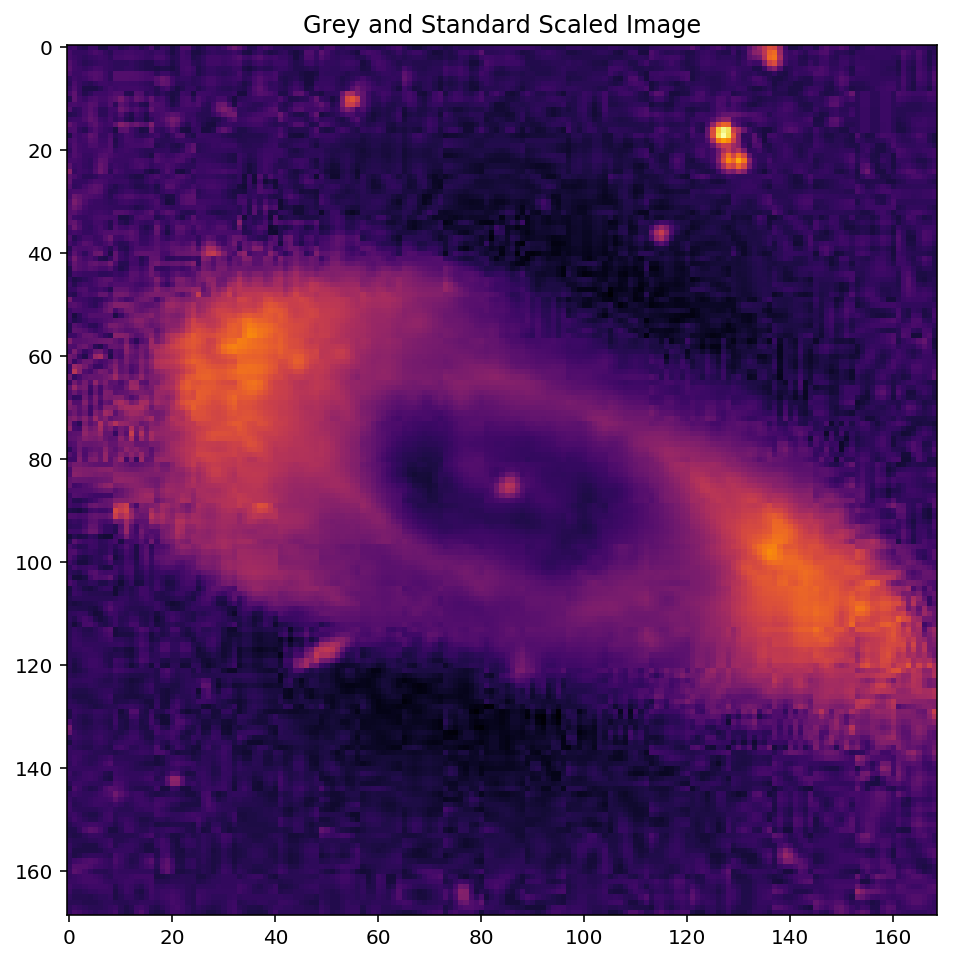

In [196]:
#Grab an image from the training set (91 just happened to be a particularily good looking galaxy)
image_num = 91
img = X_train[image_num,:,:,0]
img_sample = img.reshape(1,169,169,1)
from keras import models
layer_outputs = [layer.output for layer in CNN_model.layers[:8]]
activation_model = models.Model(inputs=CNN_model.input,output=layer_outputs)
activations = activation_model.predict(img_sample)
plt.figure(figsize=(8,8))
plt.imshow(img,cmap='inferno')
plt.title('Grey and Standard Scaled Image')
plt.savefig('SampleGreyStandardizedImage')

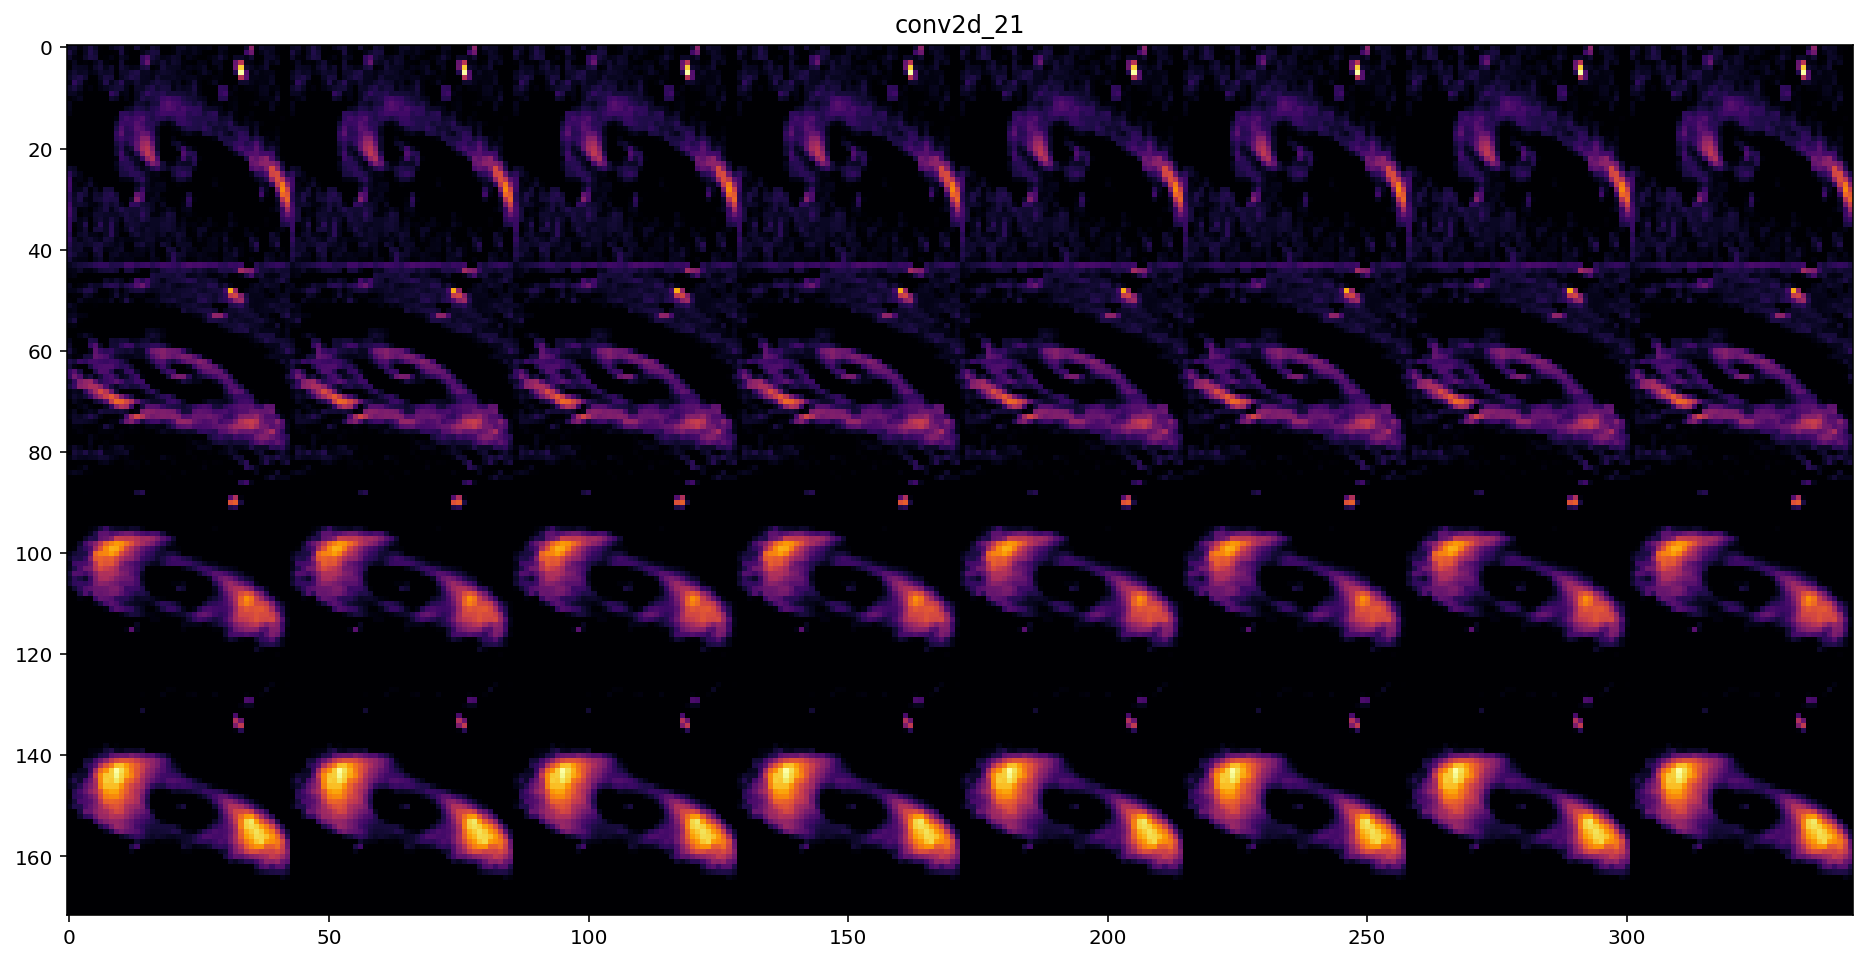

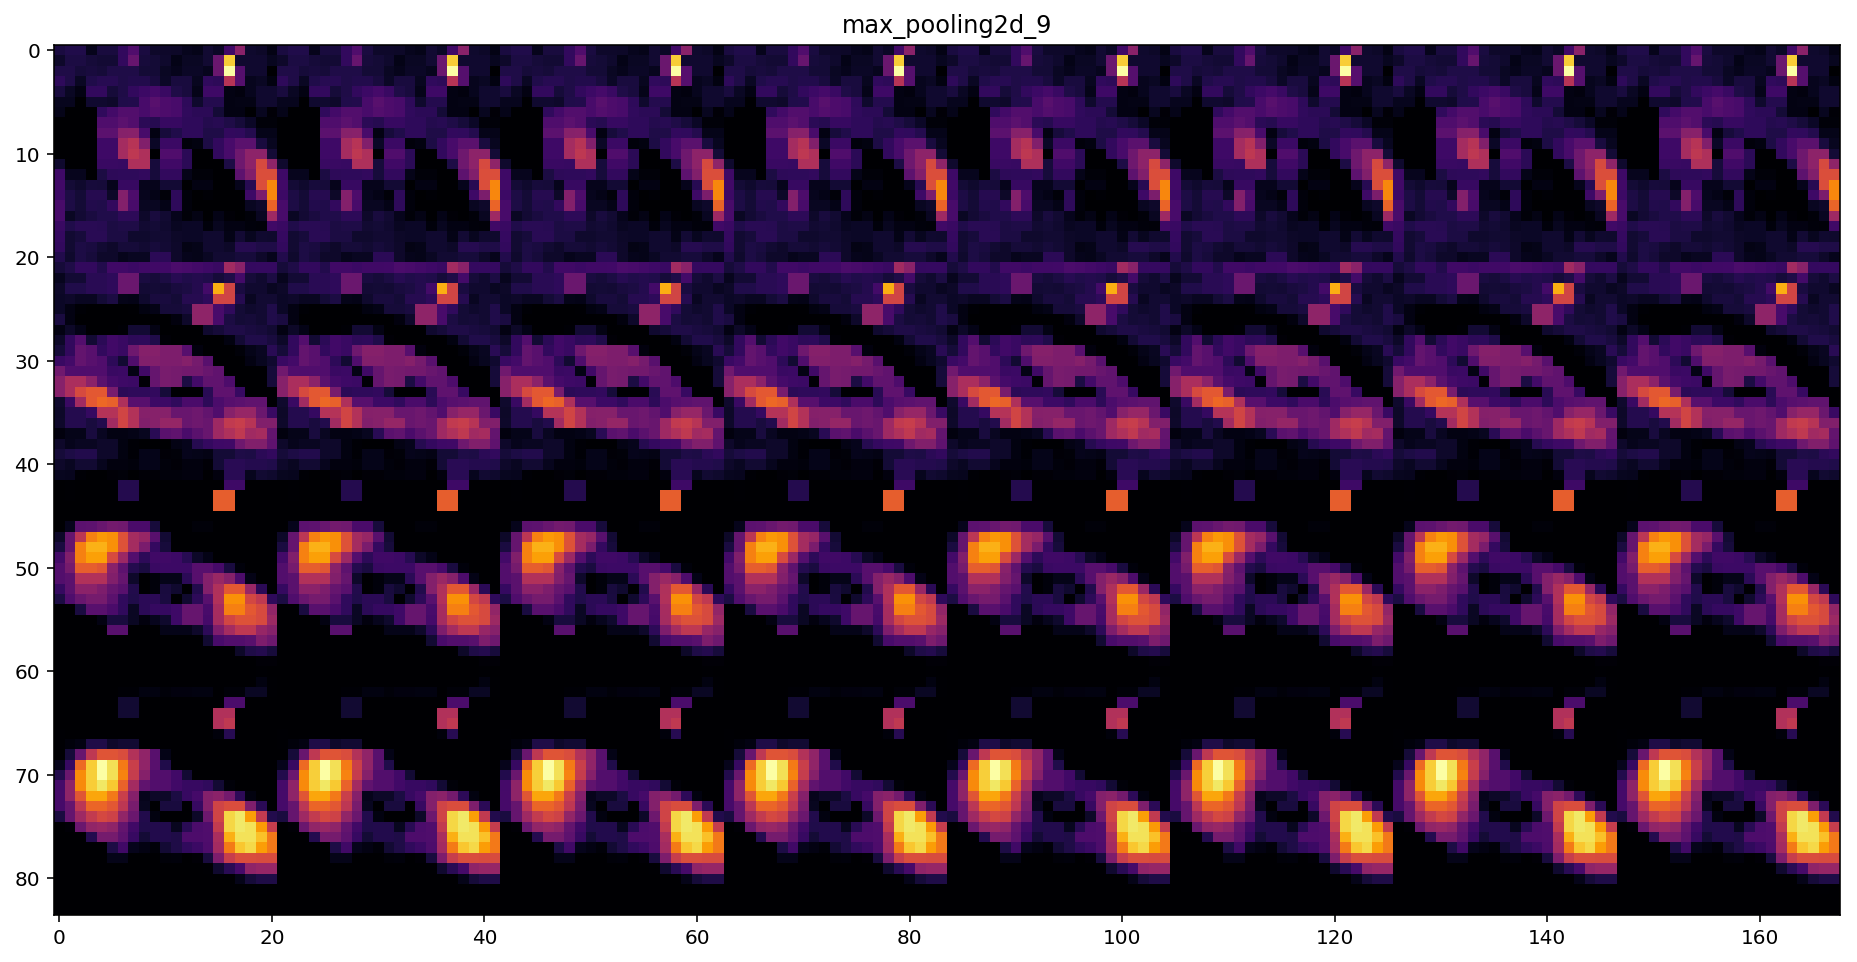

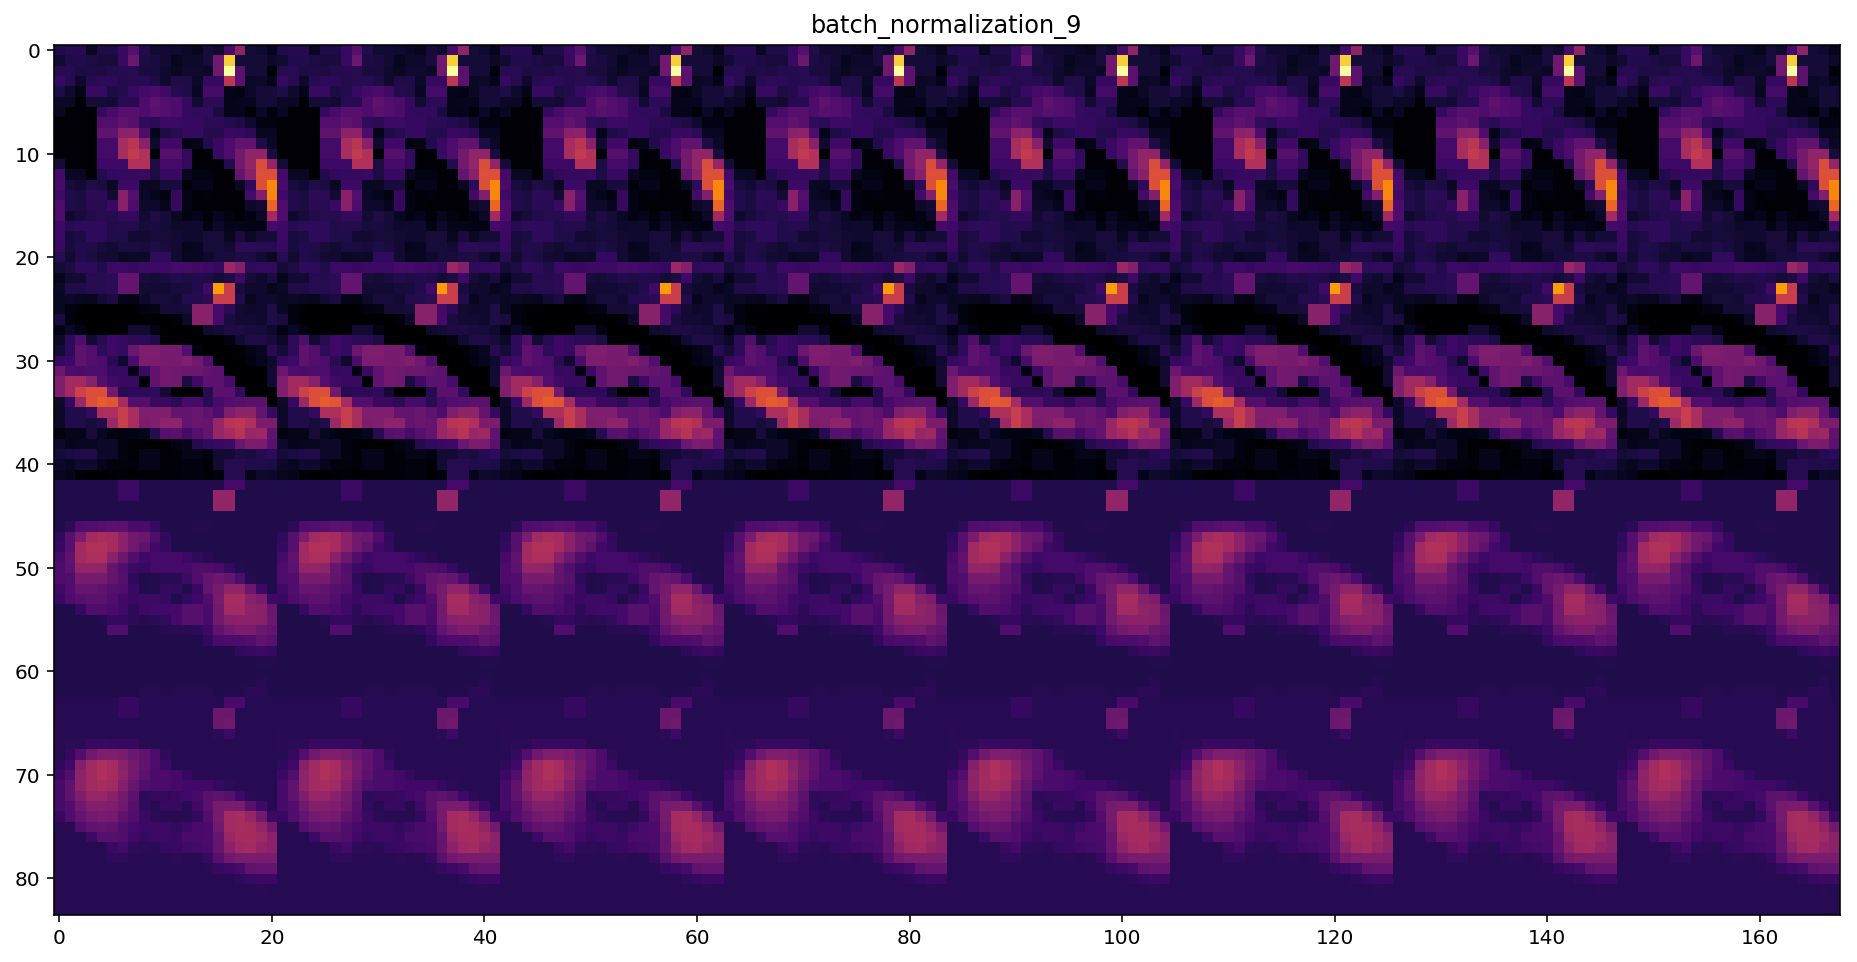

In [188]:
#Visulaizing Convolutional Layers of Network (Modified code used in "Deep Learning with Python" by Francois Challet)

layer_names = []

#Limited to first three layers
for layer in CNN_model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 8
for layer_name, layer_activation in zip(layer_names,activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,
                                             col*images_per_row]
            display_grid[col*size :(col+1)*size,
                        row*size : (row+1)*size] = channel_image
    scale = 1./size
    plt.figure(figsize=(2*scale*display_grid.shape[1],
                       2*scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid,aspect='auto',cmap='inferno')
    #plt.savefig(layer_name)
